# Build Visualizations for Rating Evaluation


In [566]:
# Get role and person to compare
role_id = 22
#person_id = 5
#person_id_1 = 10
#person_id_2 = 5
#person_id_3 = 5

## Import Libraries

In [567]:
import pandas as pd
import numpy as np

## Get Role Data

In [568]:
# Get the role from the collected data from the survey
role = pd.read_csv(filepath_or_buffer="../2-data/survey_roles.csv", sep=",", encoding="latin1")
role = role[role['id']==role_id]
role_skills = role['skills'].values[0].split(';')
role_experience = role['explevel'].values[0]

print(role_id)
print(role_skills)
print(role_experience)

22
['JavaScript', 'PostgreSQL', 'jQuery', 'React.js', 'React Native', 'Docker', 'Kubernetes']
Associate


In [569]:
# Tokenize the skills
role['skills'] = role['skills'].apply(lambda x: x.split(';'))
#role['skills'] = role['skills'].apply(set)

role

,id,skills,explevel,name
6,22,"[JavaScript, PostgreSQL, jQuery, React.js, Rea...",Associate,Software Engineer - Frontend


In [570]:
df_role_skills = role.explode('skills')[['id', 'skills']]
df_role_skills['skills'] = df_role_skills['skills'].str.strip()
#df_role_skills['source'] = 'role-skills'
df_role_skills

,id,skills
6,22,JavaScript
6,22,PostgreSQL
6,22,jQuery
6,22,React.js
6,22,React Native
6,22,Docker
6,22,Kubernetes


# Get Employees Data

In [571]:
# Read the employees dataset - from the data entered in the survey
df_people = pd.read_csv(filepath_or_buffer=f"../6-results/rating_role_{role_id}.csv", sep=",", encoding="latin1")

# Get only required columns
#df_people = df_people[(df_people['id']==person_id_1) | (df_people['id']==person_id_2) | (df_people['id']==person_id_3)]
df_people = df_people[(df_people['rank-model1']==1) | (df_people['rank-model2']==1) | (df_people['rank-model3']==1)]


person_id_1 = df_people['id'][(df_people['rank-model1']==1)].values[0]
person_id_2 = df_people['id'][(df_people['rank-model2']==1)].values[0]
person_id_3 = df_people['id'][(df_people['rank-model3']==1)].values[0]

df_people = df_people[['id', 'skills', 'skills-want']]

# Tokenize the skills
df_people['skills'] = df_people['skills'].apply(lambda x: x.replace("'", ""))
df_people['skills'] = df_people['skills'].apply(lambda x: x.replace("[", ""))
df_people['skills'] = df_people['skills'].apply(lambda x: x.replace("]", ""))

df_people['skills'] = df_people['skills'].apply(lambda x: x.split(','))
#df_people['skills'] = df_people['skills'].apply(set)

df_people['skills-want'] = df_people['skills-want'].apply(lambda x: x.replace("'", ""))
df_people['skills-want'] = df_people['skills-want'].apply(lambda x: x.replace("[", ""))
df_people['skills-want'] = df_people['skills-want'].apply(lambda x: x.replace("]", ""))
df_people['skills-want'] = df_people['skills-want'].apply(lambda x: x.split(','))
#df_people['skills-want'] = df_people['skills-want'].apply(set)


df_people


,id,skills,skills-want
1,4,"[HTML/CSS, JavaScript, Kotlin, TypeScript, ...","[HTML/CSS, JavaScript, TypeScript, AWS, Fi..."
3,15,"[Go, Java, JavaScript, MySQL, PostgreSQL, ...","[Java, TypeScript, DynamoDB, Microsoft SQL ..."


In [572]:
df_person_skills = df_people.explode('skills')[['id', 'skills']]
df_person_skills['skills'] = df_person_skills['skills'].str.strip()
df_person_skills#['source'] = 'person-skills'


,id,skills
1,4,HTML/CSS
1,4,JavaScript
1,4,Kotlin
1,4,TypeScript
1,4,AWS
1,4,Firebase
1,4,Microsoft Azure
1,4,Node.js
1,4,React.js
1,4,React Native


In [573]:
df_person_interests = df_people.explode('skills-want')[['id', 'skills-want']]
df_person_interests['skills'] = df_person_interests['skills-want']
#df_person_interests['source'] = 'person-interests'
#df_person_interests = df_person_interests[['id', 'skills', 'source']]
df_person_interests = df_person_interests[['id', 'skills']]
df_person_interests['skills'] = df_person_interests['skills'].str.strip()
df_person_interests


,id,skills
1,4,HTML/CSS
1,4,JavaScript
1,4,TypeScript
1,4,AWS
1,4,Firebase
1,4,Angular.js
1,4,Next.js
1,4,React.js
1,4,Vue.js
1,4,React Native


# Compute Number for each combination

In [574]:
from sqlalchemy import create_engine

def create_table(name, df):
    # Create a connection to the database
    engine = create_engine('sqlite:///database.db')

    # Load the DataFrame into a table
    df.to_sql(f'{name}', engine, if_exists='replace', index=False)

    # Close the database connection
    engine.dispose()

create_table('person_skills', df_person_skills)
create_table('person_interests', df_person_interests)
create_table('role_skills', df_role_skills)


In [575]:
def query_database(sql):
    # Create a connection to the database
    engine = create_engine('sqlite:///database.db')

    # Query the data
    query = sql
    result = engine.execute(query)

    # Fetch all the rows from the result object
    rows = result.fetchall()

    # Convert the rows to a DataFrame
    df_result = pd.DataFrame(rows, columns=result.keys())

    # Close the database connection
    engine.dispose()

    return df_result


In [576]:
# Get total number of skills in the role
result = query_database("""
    select skills from role_skills
""")
result
all_skills = result.count()[0]
all_skills

7

In [577]:
def compute_matched_skills_only(person):
    # Get skills only
    result = query_database(f"""
        select rs.skills from role_skills rs, person_skills ps 
        where rs.skills = ps.skills and ps.id = {person} and rs.skills not in (
            select skills from person_interests where id = {person});
        """)
    result
    matched_skills_only = result.count()[0]
    return matched_skills_only



def compute_matched_skills_and_interests(person):
    
    # Get skills and interests
    result = query_database(f"""
        select rs.skills from role_skills rs, person_skills ps where rs.skills = ps.skills and ps.id = {person} and rs.skills in (select skills from person_interests where id = {person});
        """)
    result
    matched_skills_and_interests = result.count()[0]
    return matched_skills_and_interests


def compute_matched_interests_only(person):
    # Get interests only
    result = query_database(f"""
        select rs.skills from role_skills rs, person_interests pi where rs.skills = pi.skills and pi.id = {person} and rs.skills not in (select skills from person_skills where id = {person});
        """)
    result
    matched_interests_only = result.count()[0]
    return matched_interests_only



def compute_skills_not_matched(person):
    # Get skills not matched on neither skills nor interests
    result = query_database(f"""
        select rs.skills from role_skills rs where rs.skills not in (select skills from person_skills where id = {person}) and rs.skills not in (select skills from person_interests where id = {person}) ;
        """)
    result
    skills_not_matched = result.count()[0]
    return skills_not_matched




In [578]:

print(compute_matched_skills_only(person_id_1))
print(compute_matched_skills_and_interests(person_id_1))
print(compute_matched_interests_only(person_id_1))
print(compute_skills_not_matched(person_id_1))

2
2
0
3


# See Results

In [579]:
print("Total Number of Skills:", all_skills)
print("Skills only:", matched_skills_only)
print("Skills and Interests:", matched_skills_and_interests)
print("Interests only:", matched_interests_only)
print("Skills not Matched:", skills_not_matched)


Total Number of Skills: 7
Skills only: 3
Skills and Interests: 7
Interests only: 1
Skills not Matched: 1


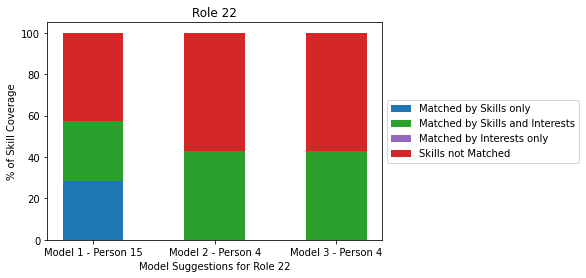

In [580]:
import matplotlib.pyplot as plt

# Create a sample DataFrame
data = {
    'Category': [f'Model 1 - Person {person_id_1}', f'Model 2 - Person {person_id_2}', f'Model 3 - Person {person_id_3}'],
    'Matched by Skills only': [compute_matched_skills_only(person_id_1), compute_matched_skills_only(person_id_2), compute_matched_skills_only(person_id_3)],
    'Matched by Skills and Interests': [compute_matched_skills_and_interests(person_id_1), compute_matched_skills_and_interests(person_id_2), compute_matched_skills_and_interests(person_id_3)],
    'Matched by Interests only': [compute_matched_interests_only(person_id_1), compute_matched_interests_only(person_id_2), compute_matched_interests_only(person_id_3)],
    'Skills not Matched': [compute_skills_not_matched(person_id_1), compute_skills_not_matched(person_id_2), compute_skills_not_matched(person_id_3)]
}
df = pd.DataFrame(data)

# Calculate the percentage for each value in each category
total = df[['Matched by Skills only', 'Matched by Skills and Interests', 'Matched by Interests only', 'Skills not Matched']].sum(axis=1)
df_percent = df[['Matched by Skills only', 'Matched by Skills and Interests', 'Matched by Interests only', 'Skills not Matched']].div(total, axis=0) * 100

# Plot the 100% stacked bar chart
fig, ax = plt.subplots()
categories = df['Category']
bar_width = 0.5

bottom = [0] * len(categories)
colors = ['tab:blue', 'tab:green', 'tab:purple', 'tab:red']

for i, col in enumerate(df_percent.columns):
    values = df_percent[col]
    ax.bar(categories, values, bar_width, bottom=bottom, color=colors[i], label=col)
    bottom += values

ax.set_ylabel('% of Skill Coverage')
ax.set_xlabel(f'Model Suggestions for Role {role_id}')
ax.set_title(f'Role {role_id}')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


In [437]:
# Save chart
plt.savefig(f'rating_role_{role_id}.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>